# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach
![Konwolucja](https://aigeekprogrammer.com/wp-content/uploads/2019/12/CNN-konwolucja-9.png)  
Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

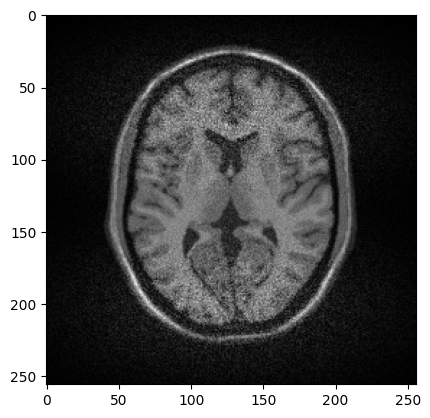

In [46]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/"

fileNames = ["MR_data.mat"]
for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, "wb").write(r.content)

mr_data = loadmat("MR_data.mat")
img = mr_data["I_noisy2"]
plt.imshow(img, cmap="gray")

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

In [47]:
def fgaussian(size: int, sigma: float):
    m = n = size
    h, k = m // 2, n // 2
    x, y = np.mgrid[-h : h + 1, -k : k + 1]
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

In [48]:
def classic_convolution(img, window: int, sigma: float):
    kernel = fgaussian(window, sigma)
    image = img.copy()

    image_padded = np.zeros((image.shape[0] + window - 1, image.shape[1] + window - 1))
    image_padded[
        (window - 1) // 2 : -(window - 1) // 2, (window - 1) // 2 : -(window - 1) // 2
    ] = image

    result = np.zeros_like(image)

    for i in range(0, image.shape[1]):
        for j in range(0, image.shape[0]):
            result[j, i] = (kernel * image_padded[j : j + window, i : i + window]).sum()

    return result

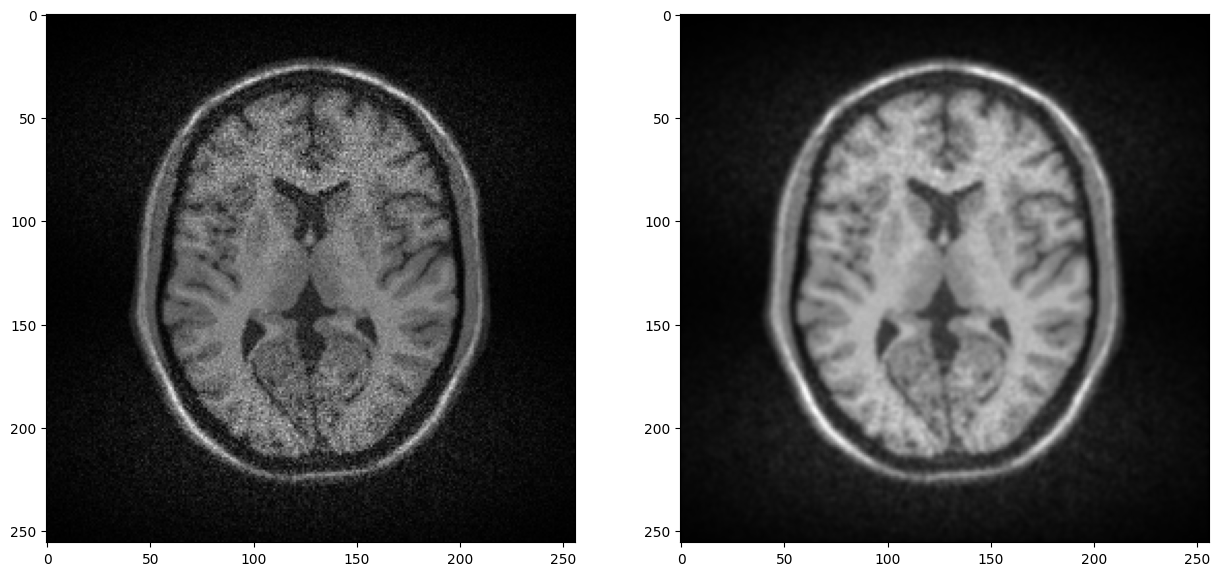

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15))
axs[0].imshow(img, cmap="gray")
axs[1].imshow(classic_convolution(img, 7, 1), cmap="gray")
plt.show()

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [50]:
def bilateral_convolution(image, W: int, sigma: float, noise_param: float):
    kernel = fgaussian(W, sigma)
    height, width = image.shape
    result = np.zeros((height, width))
    size = W // 2
    gauss = fgaussian(W, sigma)
    for i in range(size, height - size):
        for j in range(size, width - size):
            context = image[i - size : i + size + 1, j - size : j + size + 1]
            W_n = 0
            new_value = 0
            for x in range(W):
                for y in range(W):
                    light_diff = np.abs(int(context[x, y]) - int(image[i, j])).astype(
                        np.int8
                    )
                    temp = (
                        np.exp((-1) * (((light_diff) ** 2) / (2 * (noise_param**2))))
                        * gauss[x, y]
                    )
                    W_n += temp
                    new_value += temp * context[x, y]
            new_value = new_value / W_n if W_n != 0 else 0
            result[i, j] = new_value

    return result

## Show all

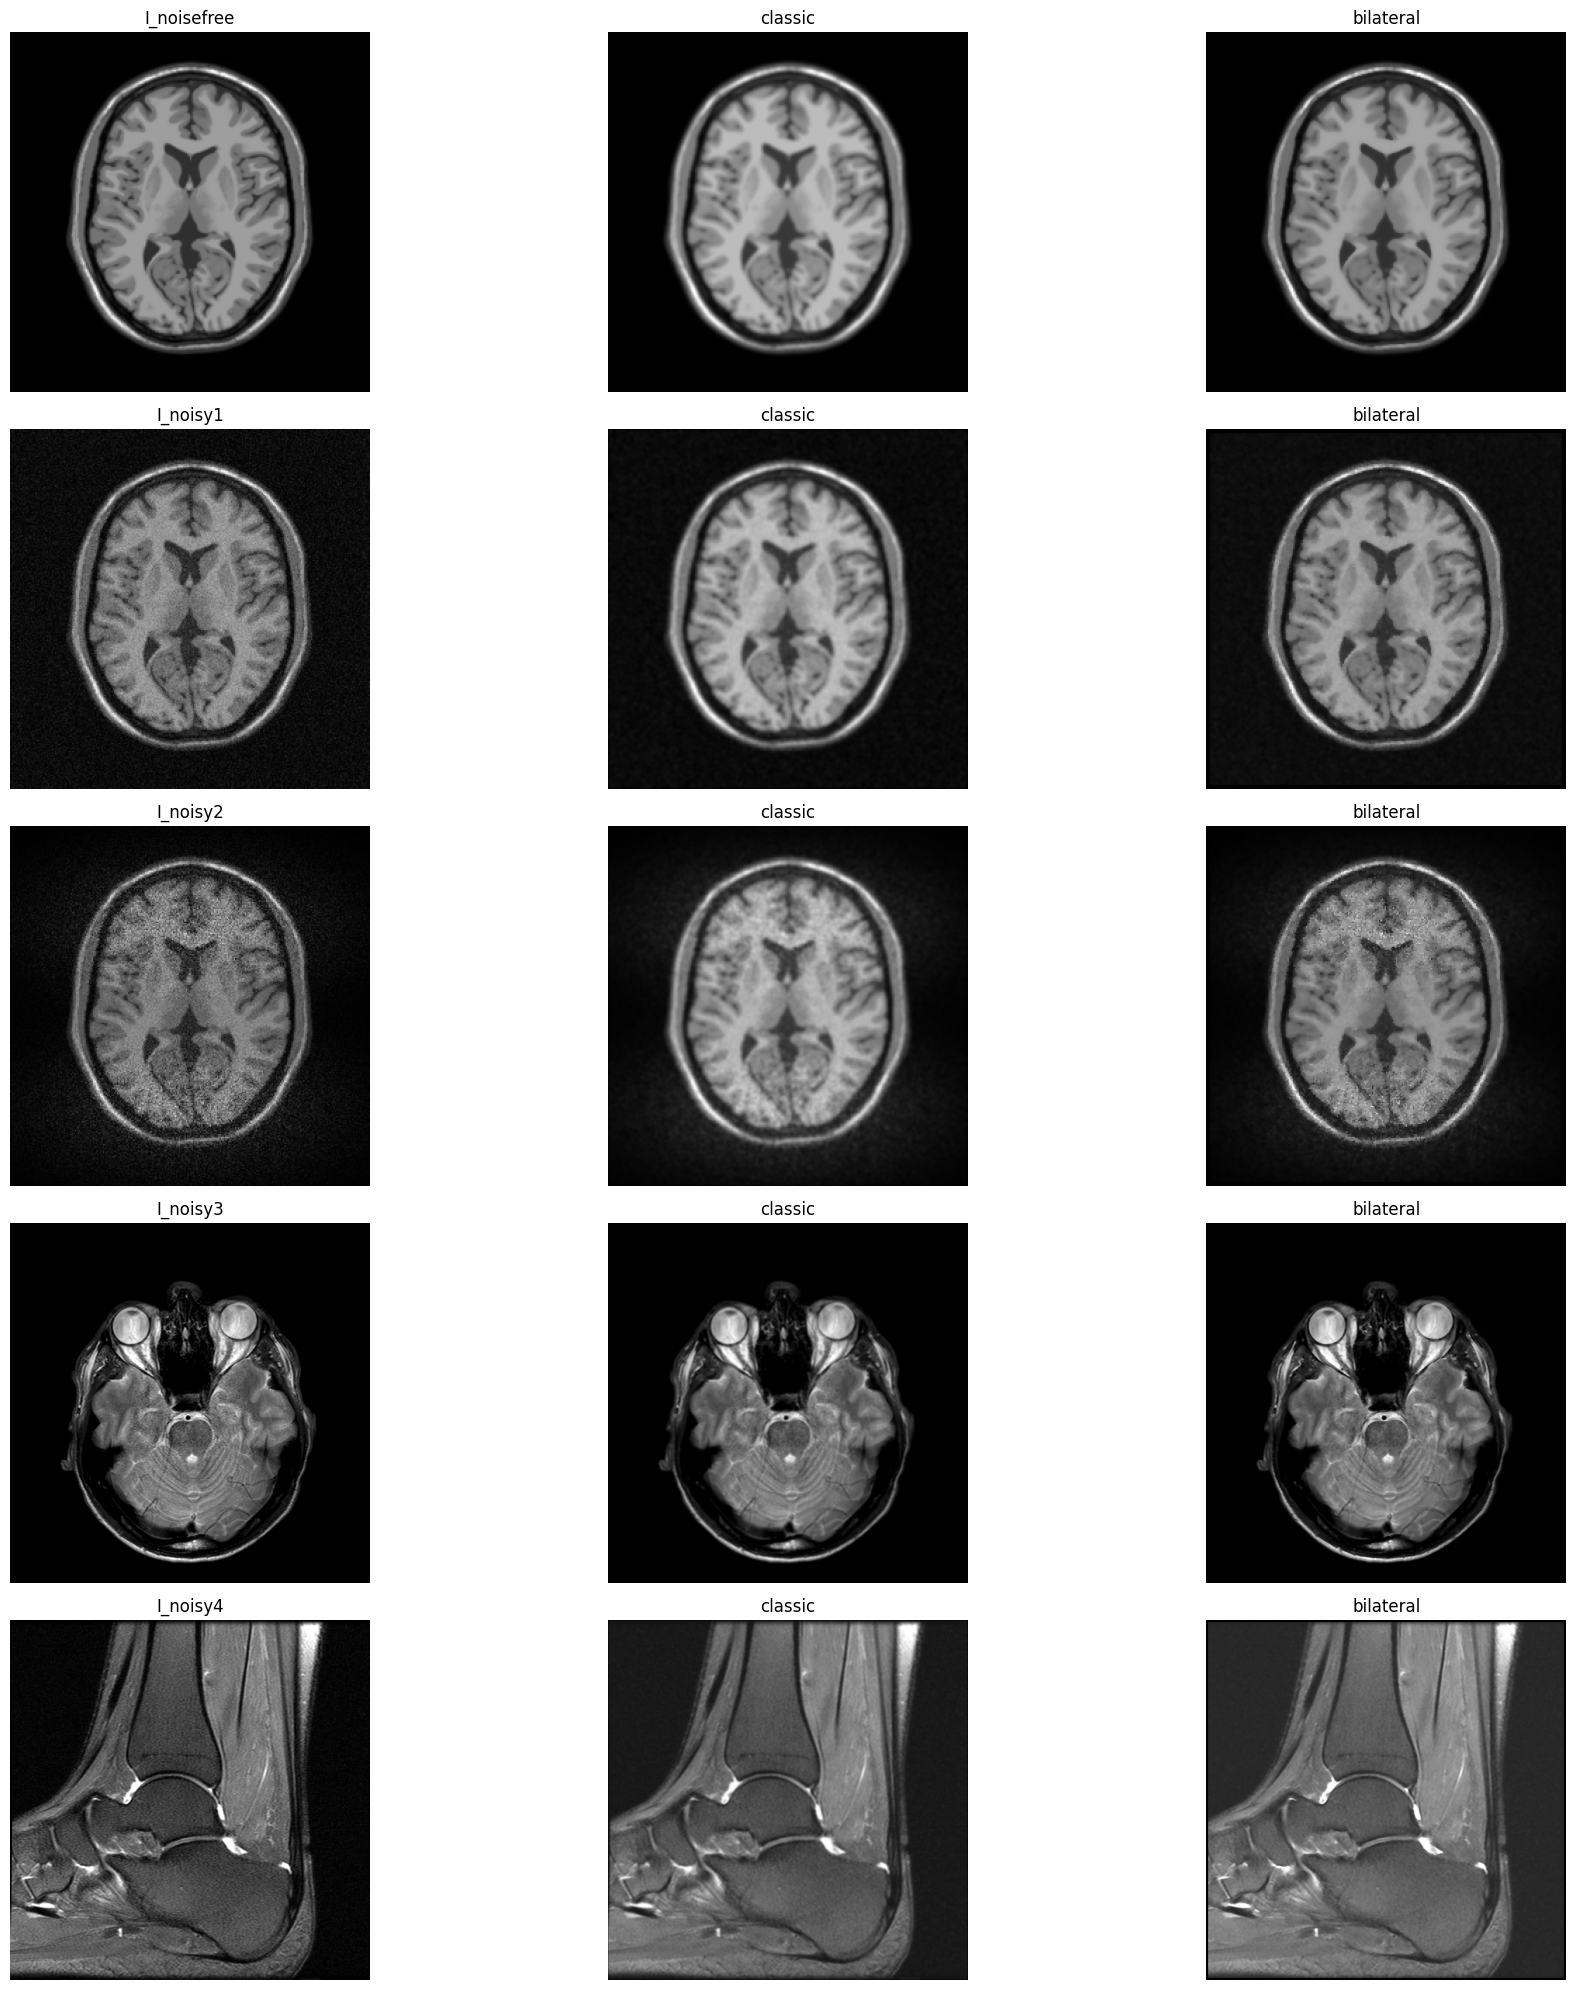

In [51]:
fileNames = ["I_noisefree", "I_noisy1", "I_noisy2", "I_noisy3", "I_noisy4"]

f, axs = plt.subplots(5, 3, figsize=(20, 20))
for i, fileName in enumerate(fileNames):
    img = mr_data[fileName]
    axs[i, 0].imshow(img, cmap="gray")
    axs[i, 0].set_title(fileName)
    axs[i, 0].axis("off")
    axs[i, 1].imshow(classic_convolution(img, 7, 1), cmap="gray")
    axs[i, 1].set_title("classic")
    axs[i, 1].axis("off")
    axs[i, 2].imshow(bilateral_convolution(img, 7, 1, 30), cmap="gray")
    axs[i, 2].set_title("bilateral")
    axs[i, 2].axis("off")
plt.tight_layout()
plt.show()